In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from  sklearn.model_selection import train_test_split
from  sklearn.metrics import classification_report, confusion_matrix
from  sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, ConfusionMatrixDisplay

In [46]:
pip --version

Note: you may need to restart the kernel to use updated packages.pip 22.3.1 from C:\anaconda\lib\site-packages\pip (python 3.10)




In [47]:
!pip install tensorflow

In [48]:
!pip install scikeras

In [49]:
df=pd.read_csv("Preprocessed_Dataa.csv")

In [50]:
# df.info()

In [51]:
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")

In [52]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['failure_encoded'] = encoder.fit_transform(df['failure'])

In [53]:
encoder.classes_

array(['comp1', 'comp2', 'comp3', 'comp4', 'none'], dtype=object)

In [54]:
dict(zip(encoder.inverse_transform([0,1,2,3,4]),[0,1,2,3,4]))

{'comp1': 0, 'comp2': 1, 'comp3': 2, 'comp4': 3, 'none': 4}

In [55]:
df=df.drop(columns="failure", axis=1)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290642 entries, 0 to 290641
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   machineID          290642 non-null  int64         
 1   datetime           290642 non-null  datetime64[ns]
 2   voltmean_3h        290642 non-null  float64       
 3   rotatemean_3h      290642 non-null  float64       
 4   pressuremean_3h    290642 non-null  float64       
 5   vibrationmean_3h   290642 non-null  float64       
 6   voltsd_3h          290642 non-null  float64       
 7   rotatesd_3h        290642 non-null  float64       
 8   pressuresd_3h      290642 non-null  float64       
 9   vibrationsd_3h     290642 non-null  float64       
 10  voltmean_24h       290642 non-null  float64       
 11  rotatemean_24h     290642 non-null  float64       
 12  pressuremean_24h   290642 non-null  float64       
 13  vibrationmean_24h  290642 non-null  float64 

In [57]:
# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    Y_train = df.loc[df['datetime'] < last_train_date, 'failure_encoded']
    X_train = df.loc[df['datetime'] < last_train_date].drop(columns=['datetime', 'machineID', 'failure_encoded'])
    X_test = df.loc[df['datetime'] > first_test_date].drop(columns=['datetime','machineID','failure_encoded'])
    Y_test = df.loc[df['datetime'] > first_test_date, 'failure_encoded']

In [58]:
df.shape

(290642, 33)

In [59]:
print("Y_train type:", type(Y_train))
print("Y_train shape:", Y_train.shape)
print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape)
print("X_test type:", type(X_test))
print("X_test shape:", X_test.shape)
print("Y_test type:", type(Y_test))
print("Y_test shape:", Y_test.shape)

Y_train type: <class 'pandas.core.series.Series'>
Y_train shape: (216732,)
X_train type: <class 'pandas.core.frame.DataFrame'>
X_train shape: (216732, 30)
X_test type: <class 'pandas.core.frame.DataFrame'>
X_test shape: (73110, 30)
Y_test type: <class 'pandas.core.series.Series'>
Y_test shape: (73110,)


In [60]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn')
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [61]:
X_train =X_train.astype(np.float32)
X_test =X_test.astype(np.float32)
X = df.drop(columns=['datetime', 'machineID', 'failure_encoded']).astype(np.float32)

In [62]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(Y_train, num_classes=5)
Y_test = to_categorical(Y_test, num_classes=5)

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=600, output_dim=16, input_length=30))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=2, batch_size=64, validation_data=(X_test, Y_test))

C:\anaconda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/2
3387/3387 ━━━━━━━━━━━━━━━━━━━━ 410s 107ms/step - accuracy: 0.9841 - loss: 0.1054 - val_accuracy: 0.9947 - val_loss: 0.0190
Epoch 2/2
3387/3387 ━━━━━━━━━━━━━━━━━━━━ 316s 93ms/step - accuracy: 0.9961 - loss: 0.0122 - val_accuracy: 0.9971 - val_loss: 0.0136


In [68]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

2285/2285 ━━━━━━━━━━━━━━━━━━━━ 84s 37ms/step - accuracy: 0.9977 - loss: 0.0100
Test loss: 0.0136, Test accuracy: 0.9971


In [69]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

2285/2285 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step


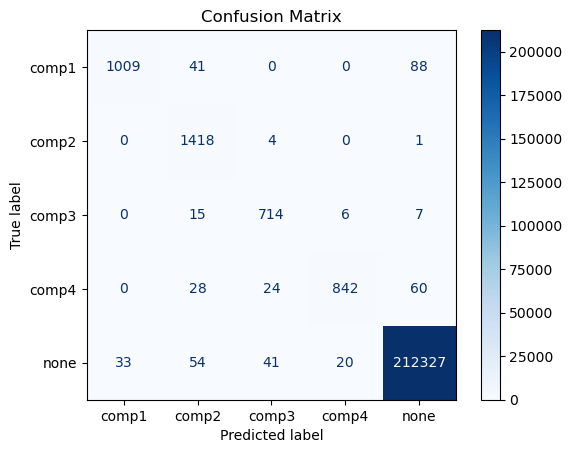

In [66]:
# Convert Y_test from one-hot encoded to categorical labels
Y_test_labels = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_test_labels, y_pred)

# Display the confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['comp1', 'comp2', 'comp3', 'comp4', 'none'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [22]:
class_names=['comp1', 'comp2', 'comp3', 'comp4', 'none']
print('Classification Report:')
print(classification_report(Y_test_labels, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       comp1       0.93      0.89      0.91       320
       comp2       0.97      0.98      0.97       548
       comp3       0.83      0.86      0.84       224
       comp4       0.98      0.66      0.79       280
        none       1.00      1.00      1.00     71738

    accuracy                           1.00     73110
   macro avg       0.94      0.88      0.90     73110
weighted avg       1.00      1.00      1.00     73110



In [23]:
# import pickle 
# vec_file= "savedmodel.pickle"
# pickle.dump(model,open(vec_file,"wb"))

In [24]:
# pwd

In [25]:
import pickle 
vec_file= "savedmodel.sav"
pickle.dump(model,open(vec_file,"wb"))

In [26]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73110 entries, 2175 to 290641
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   voltmean_3h        73110 non-null  float32
 1   rotatemean_3h      73110 non-null  float32
 2   pressuremean_3h    73110 non-null  float32
 3   vibrationmean_3h   73110 non-null  float32
 4   voltsd_3h          73110 non-null  float32
 5   rotatesd_3h        73110 non-null  float32
 6   pressuresd_3h      73110 non-null  float32
 7   vibrationsd_3h     73110 non-null  float32
 8   voltmean_24h       73110 non-null  float32
 9   rotatemean_24h     73110 non-null  float32
 10  pressuremean_24h   73110 non-null  float32
 11  vibrationmean_24h  73110 non-null  float32
 12  voltsd_24h         73110 non-null  float32
 13  rotatesd_24h       73110 non-null  float32
 14  pressuresd_24h     73110 non-null  float32
 15  vibrationsd_24h    73110 non-null  float32
 16  error1count       

In [27]:
import pickle 
vec_file= "savedmodel.sav"
load_model=pickle.load(open(vec_file,"rb"))

In [28]:
# Input data (one sample with 30 features)
input_data = [[180.13378397109702, 440.60832011257327, 94.13796949854344, 41.55154362650146, 21.322734791827322, 
              48.77051196643331, 2.1356837326217306, 10.037208062658594, 169.73380889577274, 445.17986460181123, 
              96.7971129620009, 40.38515998915177, 15.72696995154812, 39.64811571652482, 11.904699751203538, 
              5.601190880037356, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 215.0, 155.0, 170.0, 18.0, 0.0, 0.0, 1.0, 0.0]]

# Reshape the input data to match the model's expected input shape (samples, features)
input_data_reshaped = np.array(input_data).reshape(1, 30)

# Make the prediction
y_pred_prob = load_model.predict(input_data_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print the predicted class
class_labels = ['comp1', 'comp2', 'comp3', 'comp4', 'none']
predicted_class = class_labels[y_pred[0]]
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: none
